# Process 0.25˚ GPWv4 Netcdf to create a population-only file and add intermediate years

- Use the pre-processed NASA population data which is already on the 0.5˚ grid instead of doing this custom.

- We also want to use the demographic data provided in the same way

- First want to interpolate the population to all years

## Note on pixel coordinates and transform to ERA coordinates

The coordinate system used by GPW doesn't match the one used by ERA-Interim: ERA uses 0-360 longitude . GPW uses -180 to 180, so they are offset by 180deg relative to the ERA files.

GPW also has a different cell referencing, you can see best in the 30min netcdf files because the coords are e.g. 0.25, 0.75 etc while ERA is 0, 0.5 etc.

GPW is based on the 'pixel is area' convention which we can prove because reading the tags in the TIFF files we see  the entry `'AREA_OR_POINT': 'Area'`

At a best estimate, ERA values (it seems) refer to the top-left of the grid cells. LLet us anyway make this simplifying assumption, because then to transform GPW to ERA grid just means re-labelling the axes of the NETCDF files such that the lat/lon coords also refer to the top-left corder instead of the centre - basically just need to shift the values by 0.25degrees.

NOTE THAT for the previous years, we projected the weather data onto the high resolution population data. Since the population data was such high resolution it didn't actually matter wether we referred to the grid centre or corner because we could treat the pixels as points anyway. With the new approach we want to align everything to 0.5degree resolution which makes everything much simpler.

In [1]:
import numpy as np
import pandas as pd
import rasterio
import xarray as xr
import matplotlib.pyplot as plt

from config import POP_DATA_SRC, DATA_SRC

plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
# IMPORTANT TO SET THIS
xr.set_options(keep_attrs=True)

In [2]:
gpw_rev11_folder = POP_DATA_SRC / 'gpwv4' / 'gpw-v4-population-count-adjusted-to-2015-unwpp-country-totals-rev11_totpop_15_min_nc'

In [3]:
metadata = pd.read_csv( gpw_rev11_folder / 'gpw_v4_netcdf_contents_rev11.csv')

In [4]:
un_wpp_pop_meta = metadata[metadata.file_name == 'gpw_v4_population_count_rev11_adjusted']

In [5]:
un_wpp_pop_meta

file_name  order  \
40  gpw_v4_population_count_rev11_adjusted      1   
41  gpw_v4_population_count_rev11_adjusted      2   
42  gpw_v4_population_count_rev11_adjusted      3   
43  gpw_v4_population_count_rev11_adjusted      4   
44  gpw_v4_population_count_rev11_adjusted      5   
45  gpw_v4_population_count_rev11_adjusted      6   
46  gpw_v4_population_count_rev11_adjusted      7   
47  gpw_v4_population_count_rev11_adjusted      8   
48  gpw_v4_population_count_rev11_adjusted      9   
49  gpw_v4_population_count_rev11_adjusted     10   
50  gpw_v4_population_count_rev11_adjusted     11   
51  gpw_v4_population_count_rev11_adjusted     12   
52  gpw_v4_population_count_rev11_adjusted     13   
53  gpw_v4_population_count_rev11_adjusted     14   
54  gpw_v4_population_count_rev11_adjusted     15   
55  gpw_v4_population_count_rev11_adjusted     16   
56  gpw_v4_population_count_rev11_adjusted     17   
57  gpw_v4_population_count_rev11_adjusted     18   
58  gpw_v4_population_count_rev11_adjusted     19   
59  gpw_v4_population_count_rev11_adjusted     20   

                                          raster_name  \
40     UN WPP-Adjusted Population Count, v4.11 (2000)   
41     UN WPP-Adjusted Population Count, v4.11 (2005)   
42     UN WPP-Adjusted Population Count, v4.11 (2010)   
43     UN WPP-Adjusted Population Count, v4.11 (2015)   
44     UN WPP-Adjusted Population Count, v4.11 (2020)   
45  Data Quality Indicators, v4.11 (2010): Data Co...   
46  Data Quality Indicators, v4.11 (2010): Mean Ad...   
47  Data Quality Indicators, v4.11 (2010): Water Mask   
48       Land and Water Area, v4.11 (2010): Land Area   
49      Land and Water Area, v4.11 (2010): Water Area   
50  National Identifier Grid, v4.11 (2010): Nation...   
51  National Identifier Grid, v4.11 (2010): Data Code   
52  National Identifier Grid, v4.11 (2010): Input ...   
53  National Identifier Grid, v4.11 (2010): Input ...   
54  National Identifier Grid, v4.11 (2010): Input ...   
55  National Identifier Grid, v4.11 (2010): Input ...   
56  National Identifier Grid, v4.11 (2010): Growth...   
57  National Identifier Grid, v4.11 (2010): Growth...   
58  National Identifier Grid, v4.11 (2010): Growth...   
59  National Identifier Grid, v4.11 (2010): Year o...   

                                   raster_description  
40  Population count for the year 2000 adjusted to...  
41  Population count for the year 2005 adjusted to...  
42  Population count for the year 2010 adjusted to...  
43  Population count for the year 2015 adjusted to...  
44  Population count for the year 2020 adjusted to...  
45  Categorizes pixels with estimated 0 population...  
46  Mean administrative unit area in square kilome...  
47  Displays pixels that are completely water and/...  
48  Estimates of the land area, excluding permanen...  
49  Estimates of the water area (permanent ice and...  
50  Numeric country codes corresponding to nation-...  
51  A code referencing the type of population data...  
52         The year of the input population data used  
53    Highest administrative level of input data used  
54        Administrative level of input sex data used  
55        Administrative level of input age data used  
56  The earliest year used to calculate the annual...  
57  The latest year used to calculate the annual e...  
58  The dominant administrative level used to calc...  
59  Year of the most recent census conducted in th...

# Extract, interpolate the population data and adjust coordinates to match the ERA-Interim dataset


In [6]:
dat = xr.open_dataarray(gpw_rev11_folder / 'gpw_v4_population_count_adjusted_rev11_15_min.nc')
dat.name = 'population'
width = len(dat.longitude)

Translate (roll) the dataset from the -180 to 180 range to the 0 to 360 range and re-label the longitude

Also re-label the latitude to refer to the top-left grid cell, simply shift it UP by 0.25 degrees


In [7]:
dat = dat.roll(longitude=-width // 2, roll_coords=False)
dat['longitude'] = np.arange(0, 360, 0.25)
dat['latitude'] = np.arange(90, -90, -0.25) #dat['latitude'] + 0.125
del dat.attrs['min']
del dat.attrs['max']

# Split the data array into separate variables within a dataset

In [8]:
ds = {}
for _, row in un_wpp_pop_meta.iterrows():
    da = dat.sel(raster=row.order, drop=True)
    if row.order not in [1,2,3,4,5]:
        del da.attrs['units']
    da.attrs['long_name'] = row.raster_name
#     da.attrs['name'] = row.raster_name
    ds[row.raster_name]  = da
    
gpw_ds = xr.Dataset(ds)
gpw_ds.attrs['name'] = 'UN WPP-Adjusted Population Count, v4.11'
gpw_ds.attrs['resolution'] = '15 arc-minutes'

## Interpolate the population years

Re-label the year dimension and give it actual year values instead of raster layer numbers

In [9]:
# Select only the 1st 5 rasters which correspond to the year counts
pop = dat.sel(raster=[1,2,3,4,5]).copy()
pop['raster'] = 2000 + 5*(pop.raster-1)
pop = pop.rename({'raster':'year'})
pop['year'] = pop.year.astype(np.int32)

In [10]:
# Interpolate years
pop = pop.interp(year=(np.arange(2000, 2021)))
pop.attrs['long_name'] = 'UN WPP-Adjusted Population Count, v4.11 (2000-2020)'

## Add the demographic data

Remove redundant information, save both demographic totals and percentages


In [11]:
metadata[metadata.file_name == 'gpw_v4_basic_demographic_characteristics_rev11_bt_2010_cntm']

file_name  order  \
80   gpw_v4_basic_demographic_characteristics_rev11...      1   
81   gpw_v4_basic_demographic_characteristics_rev11...      2   
82   gpw_v4_basic_demographic_characteristics_rev11...      3   
83   gpw_v4_basic_demographic_characteristics_rev11...      4   
84   gpw_v4_basic_demographic_characteristics_rev11...      5   
85   gpw_v4_basic_demographic_characteristics_rev11...      6   
86   gpw_v4_basic_demographic_characteristics_rev11...      7   
87   gpw_v4_basic_demographic_characteristics_rev11...      8   
88   gpw_v4_basic_demographic_characteristics_rev11...      9   
89   gpw_v4_basic_demographic_characteristics_rev11...     10   
90   gpw_v4_basic_demographic_characteristics_rev11...     11   
91   gpw_v4_basic_demographic_characteristics_rev11...     12   
92   gpw_v4_basic_demographic_characteristics_rev11...     13   
93   gpw_v4_basic_demographic_characteristics_rev11...     14   
94   gpw_v4_basic_demographic_characteristics_rev11...     15   
95   gpw_v4_basic_demographic_characteristics_rev11...     16   
96   gpw_v4_basic_demographic_characteristics_rev11...     17   
97   gpw_v4_basic_demographic_characteristics_rev11...     18   
98   gpw_v4_basic_demographic_characteristics_rev11...     19   
99   gpw_v4_basic_demographic_characteristics_rev11...     20   
100  gpw_v4_basic_demographic_characteristics_rev11...     21   
101  gpw_v4_basic_demographic_characteristics_rev11...     22   
102  gpw_v4_basic_demographic_characteristics_rev11...     23   
103  gpw_v4_basic_demographic_characteristics_rev11...     24   
104  gpw_v4_basic_demographic_characteristics_rev11...     25   
105  gpw_v4_basic_demographic_characteristics_rev11...     26   
106  gpw_v4_basic_demographic_characteristics_rev11...     27   
107  gpw_v4_basic_demographic_characteristics_rev11...     28   
108  gpw_v4_basic_demographic_characteristics_rev11...     29   
109  gpw_v4_basic_demographic_characteristics_rev11...     30   

                                           raster_name  \
80   Basic Demographic Characteristics, v4.11 (2010...   
81   Basic Demographic Characteristics, v4.11 (2010...   
82   Basic Demographic Characteristics, v4.11 (2010...   
83   Basic Demographic Characteristics, v4.11 (2010...   
84   Basic Demographic Characteristics, v4.11 (2010...   
85   Basic Demographic Characteristics, v4.11 (2010...   
86   Basic Demographic Characteristics, v4.11 (2010...   
87   Basic Demographic Characteristics, v4.11 (2010...   
88   Basic Demographic Characteristics, v4.11 (2010...   
89   Basic Demographic Characteristics, v4.11 (2010...   
90   Basic Demographic Characteristics, v4.11 (2010...   
91   Basic Demographic Characteristics, v4.11 (2010...   
92   Basic Demographic Characteristics, v4.11 (2010...   
93   Basic Demographic Characteristics, v4.11 (2010...   
94   Basic Demographic Characteristics, v4.11 (2010...   
95   Data Quality Indicators, v4.11 (2010): Data Co...   
96   Data Quality Indicators, v4.11 (2010): Mean Ad...   
97   Data Quality Indicators, v4.11 (2010): Water Mask   
98        Land and Water Area, v4.11 (2010): Land Area   
99       Land and Water Area, v4.11 (2010): Water Area   
100  National Identifier Grid, v4.11 (2010): Nation...   
101  National Identifier Grid, v4.11 (2010): Data Code   
102  National Identifier Grid, v4.11 (2010): Input ...   
103  National Identifier Grid, v4.11 (2010): Input ...   
104  National Identifier Grid, v4.11 (2010): Input ...   
105  National Identifier Grid, v4.11 (2010): Input ...   
106  National Identifier Grid, v4.11 (2010): Growth...   
107  National Identifier Grid, v4.11 (2010): Growth...   
108  National Identifier Grid, v4.11 (2010): Growth...   
109  National Identifier Grid, v4.11 (2010): Year o...   

                                    raster_description  
80                  Population count for the year 2010  
81      Population count ages 0 to 4 for the year 2010  
82      Population count ages 5 to 9 for the year 2010  
83

In [12]:
demog = xr.open_dataarray(POP_DATA_SRC / 'gpwv4' / 'gpw-v4-basic-demographic-characteristics-rev11_bt_cntm_15_min_nc' / 'gpw_v4_basic_demographic_characteristics_rev11_bt_2010_cntm_15_min.nc')

In [13]:
demog.name = 'Basic Demographic Characteristics, v4.11 (2010): Both, Count'
demog.attrs['long_name'] = 'Basic Demographic Characteristics, v4.11 (2010): Both, Count'

## Re-coordinate

In [14]:
width = len(demog.longitude)
demog = demog.roll(longitude=-width // 2, roll_coords=False)
demog['longitude'] = np.arange(0, 360, 0.25)
demog['latitude'] = np.arange(90, -90, -0.25)

del demog.attrs['min']
del demog.attrs['max']

> Pull out the percentage data before going on to process the demographic data (this is just because it was added later, avoid re-doing everything)

In [15]:
demog_pcts = (demog.sel(raster=np.arange(2, 15+1)) / demog.sel(raster=1)).copy()

In [16]:
demog = demog.sel(raster=np.arange(2, 15+1))
demog['raster'] =  np.arange(0, 70, 5)
demog = demog.rename({'raster':'age_band_lower_bound'})
demog['age_band_lower_bound'] = demog.age_band_lower_bound.astype(np.int32)


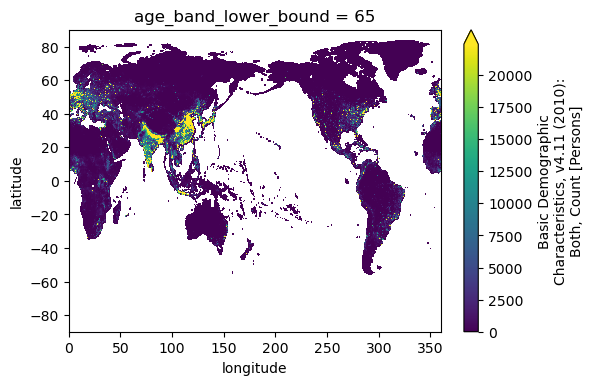

In [17]:
demog.sel(age_band_lower_bound=65).plot(robust=True)

In [18]:
# demog.to_dataset().to_netcdf(POP_DATA_SRC / 'demographic_2010_30min_era_compat.nc')

### Demographic percentages

In [19]:
demog_pcts['raster'] =  np.arange(0, 70, 5)
demog_pcts = demog_pcts.rename({'raster':'age_band_lower_bound'})
demog_pcts['age_band_lower_bound'] = demog_pcts.age_band_lower_bound.astype(np.int32)
demog_pcts.name = 'fraction_population_in_age_band'
demog_pcts.attrs['long_name'] = 'Basic Demographic Characteristics, v4.11 (2010): Both, Percent, 15 arc-minutes'
demog_pcts.attrs['units'] = 'Percent'

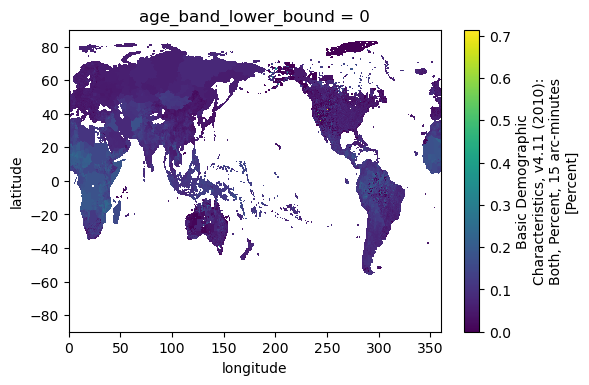

In [20]:
demog_pcts.sel(age_band_lower_bound=0).plot()

In [21]:
# demog_pcts.to_dataset().to_netcdf(POP_DATA_SRC / 'demographic_pct_2010_30min_era_compat.nc')

## Combine

In [22]:
gpw_ds['UN WPP-Adjusted Population Count, v4.11 (2000-2020)'] = pop
gpw_ds['Basic Demographic Characteristics, v4.11 (2010): Both, Count'] = demog
gpw_ds['Basic Demographic Characteristics, v4.11 (2010): Both, Percent'] = demog_pcts

## Plot

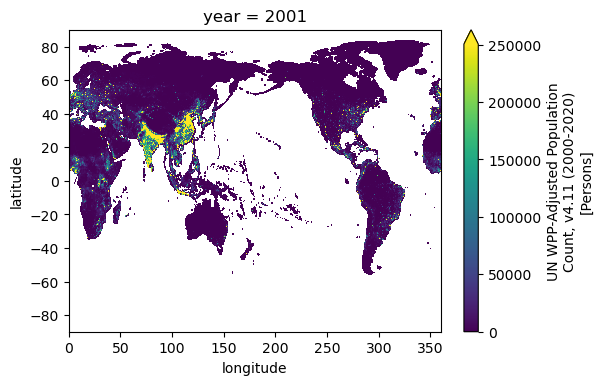

In [23]:
gpw_ds['UN WPP-Adjusted Population Count, v4.11 (2000-2020)'].sel(year=2001).plot(robust=True)

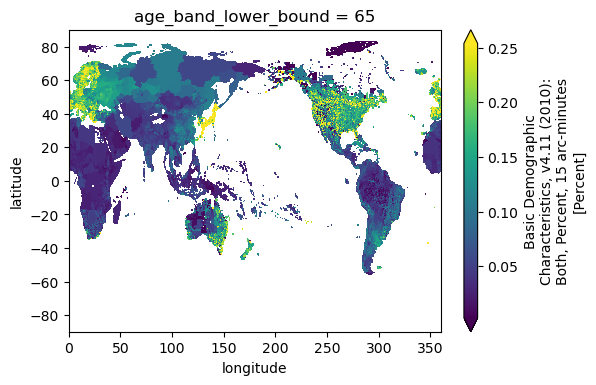

In [27]:
gpw_ds['Basic Demographic Characteristics, v4.11 (2010): Both, Percent'].sel(age_band_lower_bound=65).plot(robust=True)

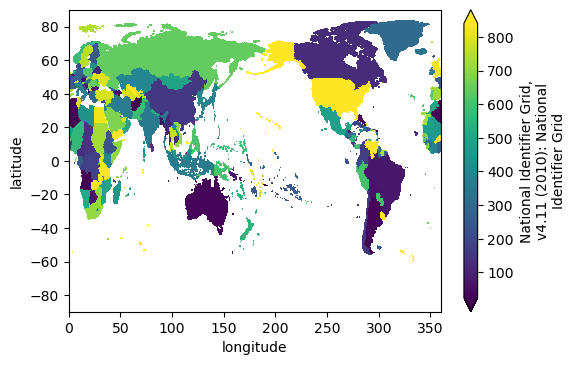

In [24]:
countries = gpw_ds['National Identifier Grid, v4.11 (2010): National Identifier Grid']
countries.where(countries < 3000).plot(robust=True)

## Save

In [25]:
gpw_ds.to_netcdf(POP_DATA_SRC / 'UN WPP-Adjusted Population Count v4.11 2000-2020 15min era compat.nc')

## Old version - save only the population in its own file

In [42]:
# Save as dataset
# pop.to_dataset().to_netcdf(POP_DATA_SRC / 'population_count_2000-2020_15min_era_compat.nc')

# ~Open and re-coordinate and re-save the water mask data~

In [53]:
# water = xr.open_rasterio(POP_DATA_SRC / 'gpwv4'/ 'gpw-v4-land-water-area-rev11_landareakm_15_min_tif' / 'gpw_v4_land_water_area_rev11_landareakm_15_min.tif')
# water = water.rename({'x':'longitude', 'y':'latitude', 'band': 'land_water_area'})

# water = water.where(water != water.nodatavals[0])

# water = water.squeeze(drop=True)
# water.name = 'land_water_area'

# width = len(water.longitude)
# water = water.roll(longitude=-width // 2, roll_coords=False)
# water['longitude'] = np.arange(0, 360, 0.25)
# water['latitude'] = pop['latitude']

# water.to_dataset().to_netcdf(POP_DATA_SRC / 'land_mask_15min_era_compat.nc')

## ~Open and re-coordinate the country code grid~

In [18]:
# countries = xr.open_rasterio(POP_DATA_SRC / 'gpwv4'/ 'gpw-v4-national-identifier-grid-rev11_30_min_tif' / 'gpw_v4_national_identifier_grid_rev11_30_min.tif')
# countries = countries.rename({'x':'longitude', 'y':'latitude', 'band': 'country_codes'})

# countries = countries.squeeze(drop=True)
# countries = countries.to_dataset(name='country_codes')

# width = len(countries.longitude)
# countries = countries.roll(longitude=-width // 2, roll_coords=False)
# countries['longitude'] = np.arange(0, 360, 0.5)
# countries['latitude'] = np.arange(90, -90, -0.5)

In [45]:
# Water is marked as code 3000something
# countries.country_codes.where(countries.country_codes < 3000).plot(robust=True)

In [20]:
# countries.to_netcdf(POP_DATA_SRC / 'country_codes_30min_era_compat.nc')

## Generate grids for the European Union (EU28/27)

> Don't forget to update post-Brexit >_<


In [9]:
COUNTRIES_RASTER = xr.open_dataset(POP_DATA_SRC / 'country_codes_30min_era_compat.nc').load()

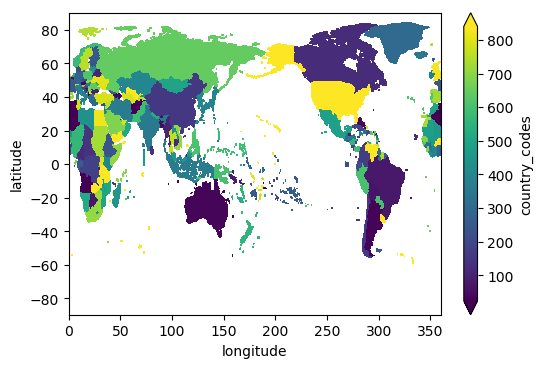

In [20]:
COUNTRIES_RASTER.country_codes.where(COUNTRIES_RASTER.country_codes < 3000).plot(robust=True)

In [23]:
# Define the countries that are in the European Union
# https://www.kaweb.co.uk/blog/list-eu-countries-and-iso-3166-1-alpha-3-code/
COUNTRY_CODES_EU = 'AUT, BEL, BGR, HRV, CYP, CZE, DNK, EST, FIN, FRA, DEU, GRC, HUN, IRL, ITA, LVA, LTU, LUX, MLT, NLD, POL, PRT, ROU, SVK, SVN, ESP, SWE, GBR'
COUNTRY_CODES_EU = COUNTRY_CODES_EU.split(',')
COUNTRY_CODES_EU = [c.strip() for c in COUNTRY_CODES_EU]

In [24]:
COUNTRY_ID_LOOKUP = DATA_SRC/ 'lancet/population/gpw_v4_national_identifier_lookup.txt'
COUNTRIES_LOOKUP = pd.read_csv(COUNTRY_ID_LOOKUP,sep='\t')

In [25]:
COUNTRIES_EU = COUNTRIES_LOOKUP[COUNTRIES_LOOKUP.ISOCODE.isin(COUNTRY_CODES_EU)]

In [26]:
country_mask =None
for _, row in COUNTRIES_EU.iterrows():
    grid_code = row.GRIDCODE
    if country_mask is None:
        country_mask = COUNTRIES_RASTER.country_codes == grid_code
    else:
        # Combine the country mask of the current country with the overall one
        # using bitwise 'OR'
        _cmask = COUNTRIES_RASTER.country_codes == grid_code
        country_mask = country_mask | _cmask

In [27]:
country_mask.to_netcdf(POP_DATA_SRC / 'countries_eu28_30min_era_compat.nc')

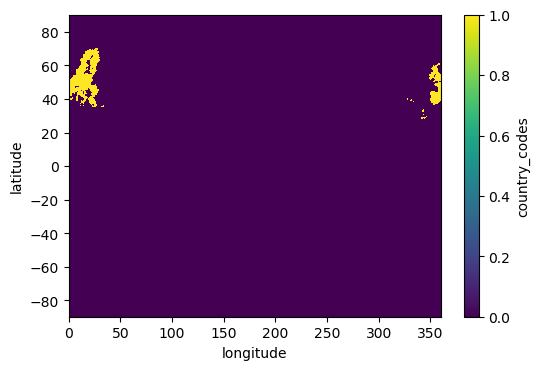

In [28]:
country_mask.plot()